## Compare CERES readout

In [19]:
import pathlib

import numpy as np
import pandas as pd
import plotnine as gg

import mygene

import seaborn as sns
import matplotlib.pyplot as plt

In [2]:
output_dir = pathlib.Path("figures")
output_dir.mkdir(exist_ok=True)
cell_health_dir = pathlib.Path("../../1.calculate-metrics/cell-health/results")

In [3]:
# Load cell health grit scores
cell_health_grit_file = pathlib.Path(f"{cell_health_dir}/cell_health_map.tsv")

cell_health_grit_df = (
    pd.read_csv(cell_health_grit_file, sep="\t")
    # .query("cor_method == 'pearson'")
    # .query("grit_replicate_summary_method == 'mean'")
)

print(cell_health_grit_df.shape)
cell_health_grit_df.head()

(681, 8)


,Metadata_gene_name,Metadata_pert_name,mean_ap,p_value,n_pos_pairs,n_total_pairs,cell_line,barcode_control
0,AKT1,AKT1-1,0.236639,0.123396,11.0,203.0,HCC44,cutting_control
1,AKT1,AKT1-2,0.198102,0.148055,11.0,203.0,HCC44,cutting_control
2,ARID1B,ARID1B-1,0.122817,0.166342,11.0,203.0,HCC44,cutting_control
3,ARID1B,ARID1B-2,0.127141,0.141236,11.0,203.0,HCC44,cutting_control
4,ATF4,ATF4-1,0.315895,0.023718,11.0,203.0,HCC44,cutting_control


In [4]:
mg = mygene.MyGeneInfo()

result = mg.querymany(
    cell_health_grit_df.Metadata_gene_name.unique().tolist(),
    scopes="symbol",
    species="human",
    fields="entrezgene,symbol,ensembl.gene,",
    as_dataframe=True,
)

ncbi_id_df = result.drop_duplicates(subset="_id").loc[:, ["_id"]].reset_index(drop=False)
ncbi_id_df.head(2)

7 input query terms found no hit:	['ATP50', 'BRAF1', 'EMPTY', 'XBP', 'Chr2', 'LacZ', 'Luc']


,query,_id
0,AKT1,207
1,ARID1B,57492


In [5]:
cell_health_grit_df = cell_health_grit_df.merge(ncbi_id_df, left_on="Metadata_gene_name", right_on="query", how="left")

print(cell_health_grit_df.shape)
cell_health_grit_df.head(2)

(681, 10)


,Metadata_gene_name,Metadata_pert_name,mean_ap,p_value,n_pos_pairs,n_total_pairs,cell_line,barcode_control,query,_id
0,AKT1,AKT1-1,0.236639,0.123396,11.0,203.0,HCC44,cutting_control,AKT1,207
1,AKT1,AKT1-2,0.198102,0.148055,11.0,203.0,HCC44,cutting_control,AKT1,207


In [6]:
# Load ceres data
ceres_dir = pathlib.Path("../../0.download-data/data/")
ceres_file = pathlib.Path(f"{ceres_dir}/ceres.csv")
depmap_sample_file = pathlib.Path(f"{ceres_dir}/depmap_sample_info.csv")

ceres_df = pd.read_csv(ceres_file, index_col=0)
depmap_sample_df = pd.read_csv(depmap_sample_file, index_col=0)

In [7]:
hgnc = [x.split(" ")[0] for x in ceres_df.columns]
ncbi_gene_id = [x.split(" ")[1].strip("()") for x in ceres_df.columns]
ncbi_gene_id

['1',
 '29974',
 '2',
 '144568',
 '127550',
 '53947',
 '51146',
 '8086',
 '65985',
 '13',
 '344752',
 '126767',
 '343066',
 '51166',
 '195827',
 '79719',
 '22848',
 '28971',
 '14',
 '15',
 '25980',
 '441376',
 '16',
 '57505',
 '80755',
 '132949',
 '60496',
 '10157',
 '26574',
 '9625',
 '18',
 '19',
 '10349',
 '26154',
 '154664',
 '20',
 '21',
 '24',
 '23461',
 '23460',
 '10347',
 '10351',
 '10350',
 '5243',
 '23456',
 '8647',
 '5244',
 '340273',
 '10058',
 '22',
 '11194',
 '23457',
 '4363',
 '89845',
 '85320',
 '94160',
 '1244',
 '8714',
 '10257',
 '10057',
 '368',
 '6833',
 '10060',
 '215',
 '225',
 '5825',
 '5826',
 '6059',
 '23',
 '10061',
 '55324',
 '9619',
 '9429',
 '64137',
 '64240',
 '64241',
 '84696',
 '55347',
 '83451',
 '26090',
 '145447',
 '84945',
 '25864',
 '84836',
 '116236',
 '7920',
 '140701',
 '81926',
 '51104',
 '58489',
 '80167',
 '11057',
 '171586',
 '63874',
 '51099',
 '57406',
 '79575',
 '10006',
 '10152',
 '51225',
 '25890',
 '25',
 '27',
 '3983',
 '84448',
 '228

In [8]:
ceres_df.columns

Index(['A1BG (1)', 'A1CF (29974)', 'A2M (2)', 'A2ML1 (144568)',
       'A3GALT2 (127550)', 'A4GALT (53947)', 'A4GNT (51146)', 'AAAS (8086)',
       'AACS (65985)', 'AADAC (13)',
       ...
       'ZWILCH (55055)', 'ZWINT (11130)', 'ZXDA (7789)', 'ZXDB (158586)',
       'ZXDC (79364)', 'ZYG11A (440590)', 'ZYG11B (79699)', 'ZYX (7791)',
       'ZZEF1 (23140)', 'ZZZ3 (26009)'],
      dtype='object', length=18119)

In [9]:
# Clean gene name column
hgnc = [x.split(" ")[0] for x in ceres_df.columns]
ncbi_gene_id = [x.split(" ")[1].strip("()") for x in ceres_df.columns]

ceres_genes_df = (
    pd.DataFrame([hgnc, ncbi_gene_id], index=["HGNC", "NCBI"])
    .transpose()
    .sort_values(by="HGNC")
    .reset_index(drop=True)
)

# Set column names to NCBI
ceres_df.columns = ncbi_gene_id

ceres_genes_df.head(3)

,HGNC,NCBI
0,A1BG,1
1,A1CF,29974
2,A2M,2


In [10]:
# Merge the data
ceres_df = depmap_sample_df.merge(ceres_df, left_index=True, right_index=True, how="right")

print(ceres_df.shape)
ceres_df.head(3)

(789, 18143)


,stripped_cell_line_name,CCLE_Name,Alias,COSMICID,sex,source,Achilles_n_replicates,cell_line_NNMD,culture_type,culture_medium,...,55055,11130,7789,158586,79364,440590,79699,7791,23140,26009
DepMap_ID,,,,,,,,,,,,,,,,,,,,,
ACH-000004,HEL,HEL_HAEMATOPOIETIC_AND_LYMPHOID_TISSUE,NaN,907053.0,Male,DSMZ,2.0,-3.079202,Suspension,RPMI + 10% FBS,...,-0.124640,-0.467130,NaN,NaN,0.255396,0.239990,-0.408827,0.290927,0.224651,-0.135151
ACH-000005,HEL9217,HEL9217_HAEMATOPOIETIC_AND_LYMPHOID_TISSUE,NaN,NaN,Male,ATCC,2.0,-2.404409,Suspension,RPMI + 10% FBS,...,-0.199184,-0.411868,-0.160226,-0.066143,0.223034,-0.076115,-0.102586,0.073836,0.026112,-0.250565
ACH-000007,LS513,LS513_LARGE_INTESTINE,NaN,907795.0,Male,ATCC,2.0,-2.586708,Adherent,RPMI + 10% FBS,...,-0.094879,-0.277592,-0.051759,0.119408,0.213447,-0.010327,-0.351529,0.085902,-0.392298,-0.440062


In [11]:
cell_lines = cell_health_grit_df.cell_line.unique().tolist()
assert all([x in ceres_df.stripped_cell_line_name.tolist() for x in cell_lines])

In [12]:
cols = ["stripped_cell_line_name"] + cell_health_grit_df._id.dropna().unique().tolist()
ceres_subset_df = (
    ceres_df.query("stripped_cell_line_name in @cell_lines")
    .loc[:, cols]
    .reset_index()
    .melt(
        id_vars=["DepMap_ID", "stripped_cell_line_name"],
        var_name="_id",
        value_name="ceres_score",
    )
)

print(ceres_subset_df.shape)
ceres_subset_df.head(3)

(156, 4)


,DepMap_ID,stripped_cell_line_name,_id,ceres_score
0,ACH-000667,HCC44,207,-0.122035
1,ACH-000681,A549,207,0.057331
2,ACH-000906,ES2,207,0.107984


In [13]:
cell_health_results_df = cell_health_grit_df.merge(
    ceres_subset_df,
    left_on=["_id", "cell_line"],
    right_on=["_id", "stripped_cell_line_name"],
    how="left",
)

cell_health_results_df = cell_health_results_df.merge(
    (
        cell_health_results_df.groupby(["cell_line", "Metadata_gene_name"])["mean_ap"]
        .mean()
        .reset_index()
        .rename({"mean_ap": "mean_mean_ap"}, axis="columns")
    ),
    left_on=["cell_line", "Metadata_gene_name"],
    right_on=["cell_line", "Metadata_gene_name"],
    how="left",
).sort_values(by="mean_ap", ascending=False)

print(cell_health_results_df.shape)
cell_health_results_df.head(3)

(681, 14)


,Metadata_gene_name,Metadata_pert_name,mean_ap,p_value,n_pos_pairs,n_total_pairs,cell_line,barcode_control,query,_id,DepMap_ID,stripped_cell_line_name,ceres_score,mean_mean_ap
525,MYC,MYC-1,1.0,0.0001,11.0,203.0,ES2,cutting_control,MYC,4609,ACH-000906,ES2,-1.918112,1.0
398,ITGAV,ITGAV-2,1.0,0.0001,11.0,179.0,A549,perturbation_control,ITGAV,3685,ACH-000681,A549,-1.051090,1.0
284,ITGAV,ITGAV-2,1.0,0.0001,11.0,203.0,A549,cutting_control,ITGAV,3685,ACH-000681,A549,-1.051090,1.0


In [31]:
cell_health_results_df["-log10(p-value)"] = -np.log10(cell_health_results_df.p_value)
cell_health_results_df["p < 0.05"] = cell_health_results_df.p_value < 0.05

/dgx1nas1/storage/data/akalinin/miniconda3/envs/map_benchmark/lib/python3.9/site-packages/plotnine/ggplot.py:587: PlotnineWarning: Saving 6 x 3.5 in image.
/dgx1nas1/storage/data/akalinin/miniconda3/envs/map_benchmark/lib/python3.9/site-packages/plotnine/ggplot.py:588: PlotnineWarning: Filename: figures/cell_health_map_ceres_comparison.png


/dgx1nas1/storage/data/akalinin/miniconda3/envs/map_benchmark/lib/python3.9/site-packages/plotnine/layer.py:364: PlotnineWarning: geom_point : Removed 63 rows containing missing values.
/dgx1nas1/storage/data/akalinin/miniconda3/envs/map_benchmark/lib/python3.9/site-packages/plotnine/layer.py:364: PlotnineWarning: geom_point : Removed 63 rows containing missing values.


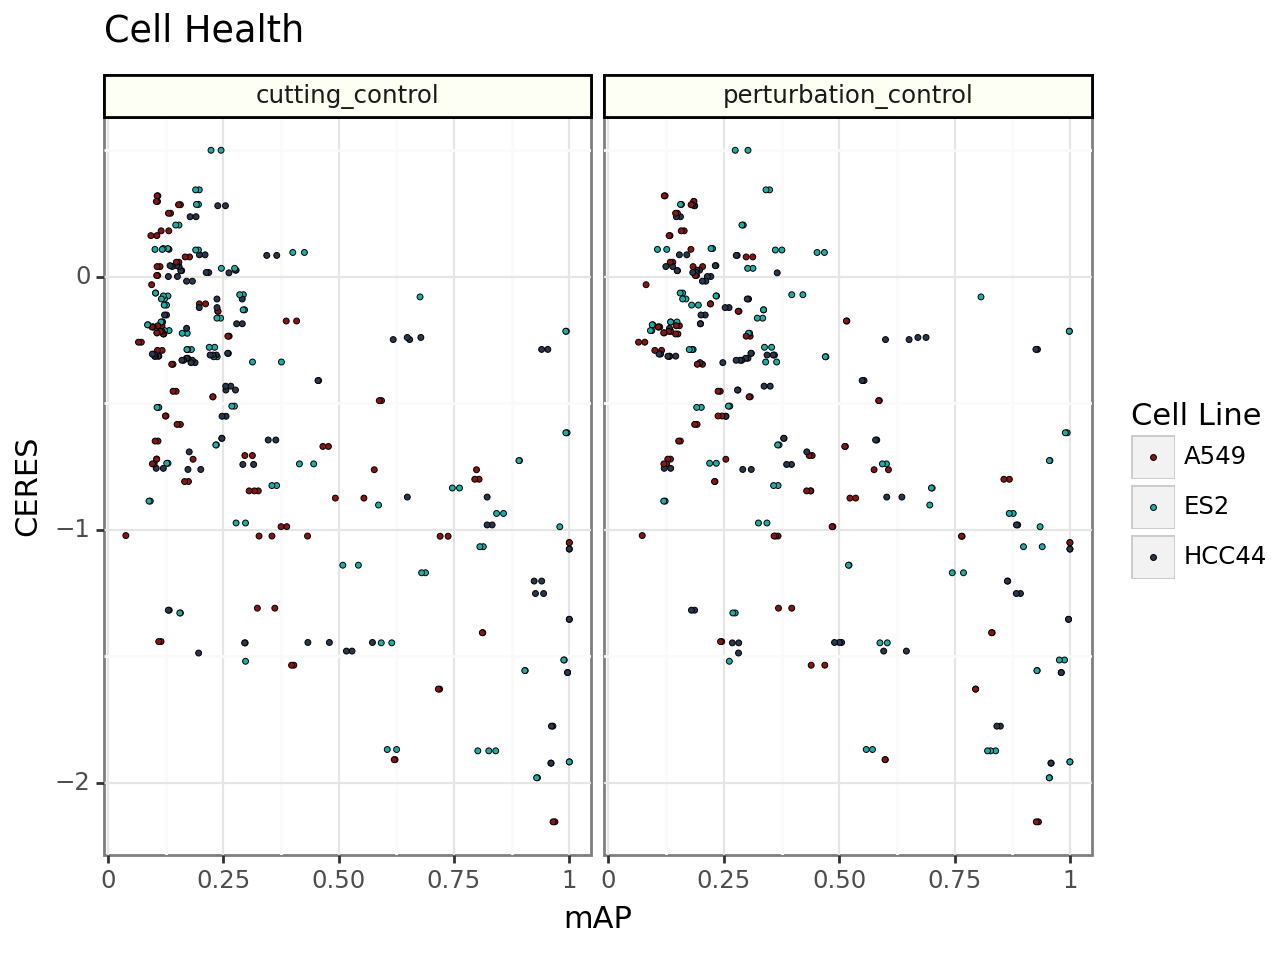

<Figure Size: (640 x 480)>

In [14]:
cell_line_colors = {"A549": "#861613", "ES2": "#1CADA8", "HCC44": "#2A364D"}

grit_ceres_comparison_gg = (
    gg.ggplot(cell_health_results_df, gg.aes(x="mean_ap", y="ceres_score"))
    + gg.geom_point(gg.aes(fill="cell_line"), size=1, stroke=0.2)
    + gg.scale_fill_manual(name="Cell Line", values=cell_line_colors)
    + gg.theme_bw()
    + gg.xlab("mAP")
    + gg.ylab("CERES")
    + gg.ggtitle("Cell Health")
    + gg.facet_wrap("~barcode_control", ncol=2)
    + gg.theme(strip_background=gg.element_rect(color="black", fill="#fdfff4"))
)

output_file = pathlib.Path(f"{output_dir}/cell_health_map_ceres_comparison.png")
grit_ceres_comparison_gg.save(output_file, dpi=500, height=3.5, width=6)

grit_ceres_comparison_gg

/dgx1nas1/storage/data/akalinin/miniconda3/envs/map_benchmark/lib/python3.9/site-packages/plotnine/ggplot.py:587: PlotnineWarning: Saving 6 x 3.5 in image.
/dgx1nas1/storage/data/akalinin/miniconda3/envs/map_benchmark/lib/python3.9/site-packages/plotnine/ggplot.py:588: PlotnineWarning: Filename: figures/cell_health_map_ceres_comparison.png
/dgx1nas1/storage/data/akalinin/miniconda3/envs/map_benchmark/lib/python3.9/site-packages/plotnine/layer.py:364: PlotnineWarning: geom_point : Removed 10 rows containing missing values.
/dgx1nas1/storage/data/akalinin/miniconda3/envs/map_benchmark/lib/python3.9/site-packages/plotnine/layer.py:364: PlotnineWarning: geom_point : Removed 10 rows containing missing values.


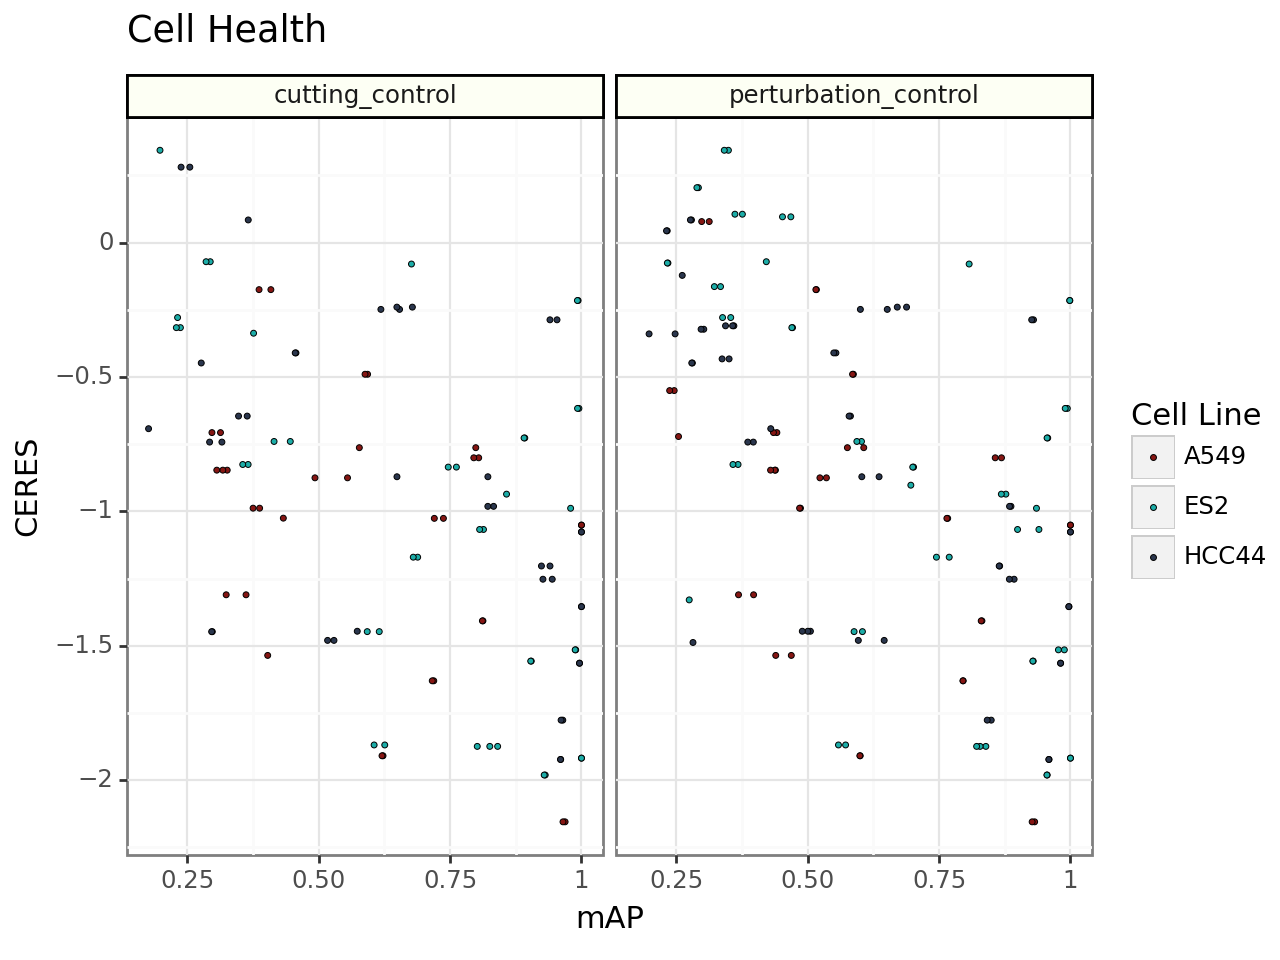

<Figure Size: (640 x 480)>

In [32]:
cell_line_colors = {"A549": "#861613", "ES2": "#1CADA8", "HCC44": "#2A364D"}

grit_ceres_comparison_gg = (
    gg.ggplot(cell_health_results_df[cell_health_results_df["p < 0.05"]], gg.aes(x="mean_ap", y="ceres_score"))
    + gg.geom_point(gg.aes(fill="cell_line"), size=1, stroke=0.2)
    + gg.scale_fill_manual(name="Cell Line", values=cell_line_colors)
    + gg.theme_bw()
    + gg.xlab("mAP")
    + gg.ylab("CERES")
    + gg.ggtitle("Cell Health")
    + gg.facet_wrap("~barcode_control", ncol=2)
    + gg.theme(strip_background=gg.element_rect(color="black", fill="#fdfff4"))
)

output_file = pathlib.Path(f"{output_dir}/cell_health_map_ceres_comparison.png")
grit_ceres_comparison_gg.save(output_file, dpi=500, height=3.5, width=6)

grit_ceres_comparison_gg

/dgx1nas1/storage/data/akalinin/miniconda3/envs/map_benchmark/lib/python3.9/site-packages/plotnine/ggplot.py:587: PlotnineWarning: Saving 6 x 3.5 in image.
/dgx1nas1/storage/data/akalinin/miniconda3/envs/map_benchmark/lib/python3.9/site-packages/plotnine/ggplot.py:588: PlotnineWarning: Filename: figures/cell_health_map_ceres_comparison.png
/dgx1nas1/storage/data/akalinin/miniconda3/envs/map_benchmark/lib/python3.9/site-packages/plotnine/layer.py:364: PlotnineWarning: geom_point : Removed 63 rows containing missing values.
/dgx1nas1/storage/data/akalinin/miniconda3/envs/map_benchmark/lib/python3.9/site-packages/plotnine/layer.py:364: PlotnineWarning: geom_point : Removed 63 rows containing missing values.


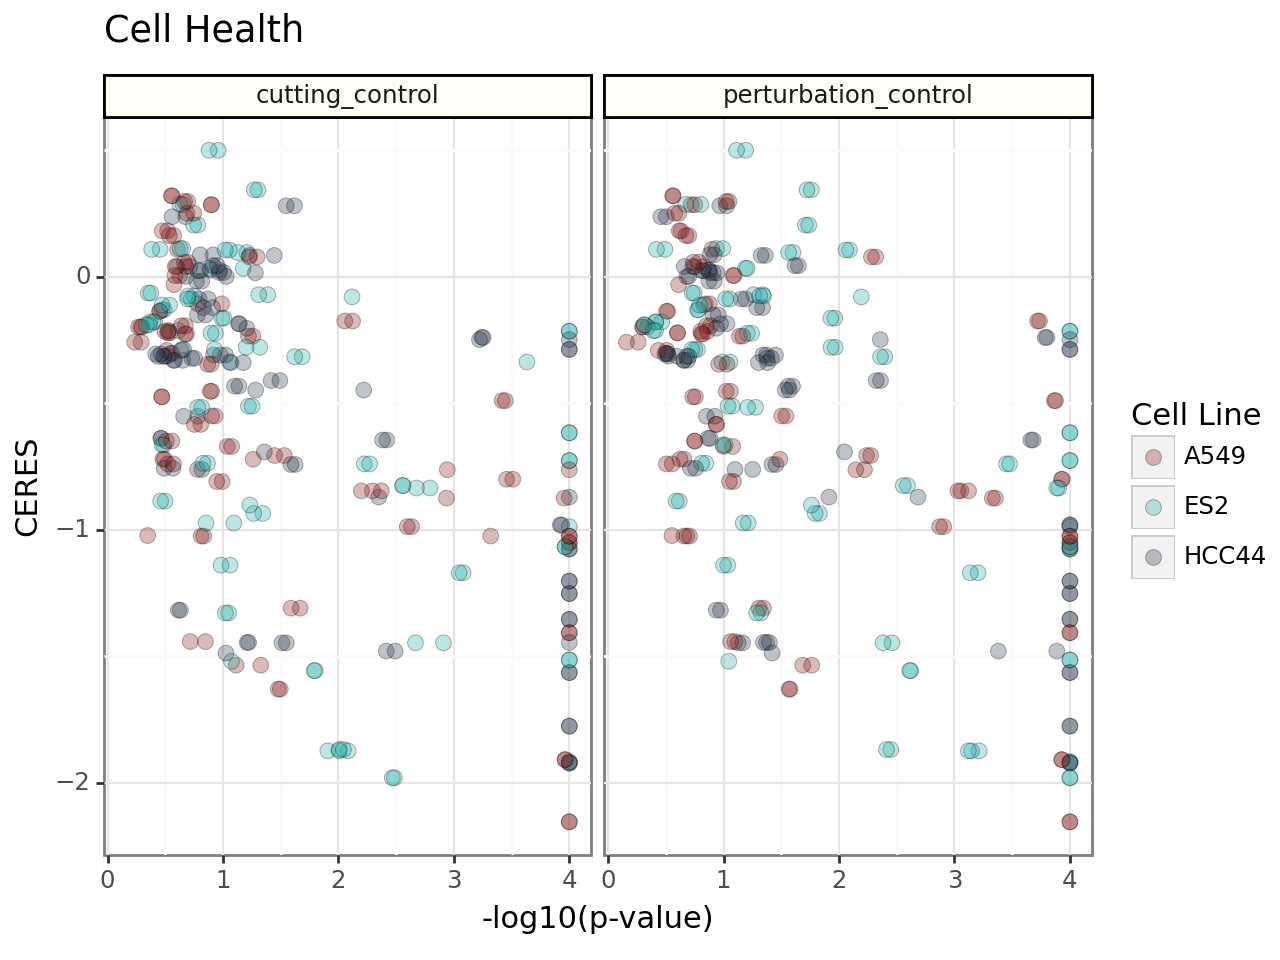

<Figure Size: (640 x 480)>

In [37]:
cell_line_colors = {"A549": "#861613", "ES2": "#1CADA8", "HCC44": "#2A364D"}

grit_ceres_comparison_gg = (
    gg.ggplot(cell_health_results_df, gg.aes(x="-log10(p-value)", y="ceres_score"))
    + gg.geom_point(gg.aes(fill="cell_line"), size=2, stroke=0.2, alpha=0.3)
    + gg.scale_fill_manual(name="Cell Line", values=cell_line_colors)
    + gg.theme_bw()
    + gg.xlab("-log10(p-value)")
    + gg.ylab("CERES")
    + gg.ggtitle("Cell Health")
    + gg.facet_wrap("~barcode_control", ncol=2)
    + gg.theme(strip_background=gg.element_rect(color="black", fill="#fdfff4"))
)

output_file = pathlib.Path(f"{output_dir}/cell_health_map_ceres_comparison.png")
grit_ceres_comparison_gg.save(output_file, dpi=500, height=3.5, width=6)

grit_ceres_comparison_gg

/dgx1nas1/storage/data/akalinin/miniconda3/envs/map_benchmark/lib/python3.9/site-packages/plotnine/ggplot.py:587: PlotnineWarning: Saving 6 x 3.5 in image.
/dgx1nas1/storage/data/akalinin/miniconda3/envs/map_benchmark/lib/python3.9/site-packages/plotnine/ggplot.py:588: PlotnineWarning: Filename: figures/cell_health_map_ceres_comparison.png
/dgx1nas1/storage/data/akalinin/miniconda3/envs/map_benchmark/lib/python3.9/site-packages/plotnine/layer.py:364: PlotnineWarning: geom_point : Removed 10 rows containing missing values.
/dgx1nas1/storage/data/akalinin/miniconda3/envs/map_benchmark/lib/python3.9/site-packages/plotnine/layer.py:364: PlotnineWarning: geom_point : Removed 10 rows containing missing values.


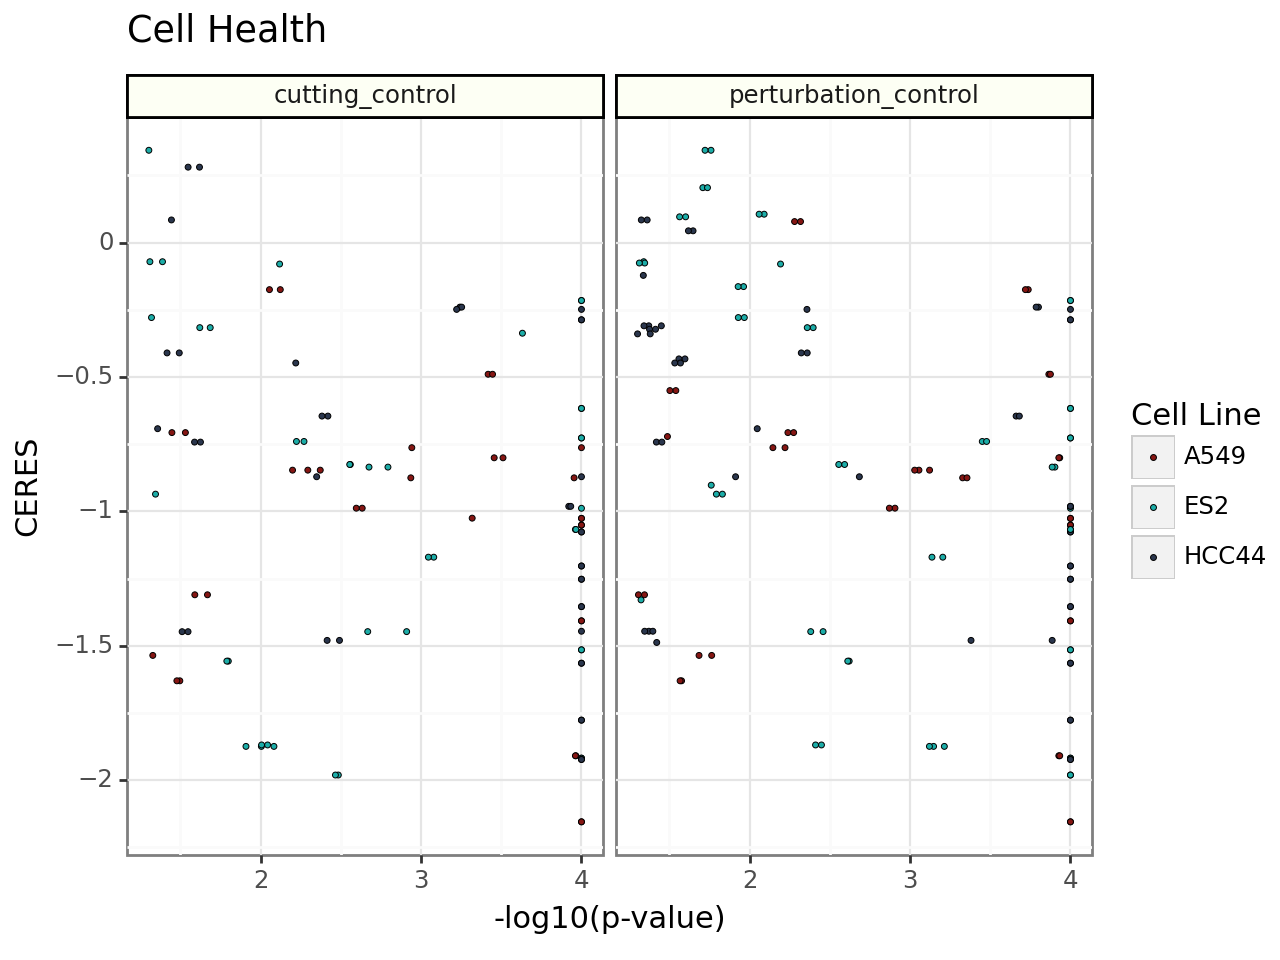

<Figure Size: (640 x 480)>

In [33]:
cell_line_colors = {"A549": "#861613", "ES2": "#1CADA8", "HCC44": "#2A364D"}

grit_ceres_comparison_gg = (
    gg.ggplot(cell_health_results_df[cell_health_results_df["p < 0.05"]], gg.aes(x="-log10(p-value)", y="ceres_score"))
    + gg.geom_point(gg.aes(fill="cell_line"), size=1, stroke=0.2)
    + gg.scale_fill_manual(name="Cell Line", values=cell_line_colors)
    + gg.theme_bw()
    + gg.xlab("-log10(p-value)")
    + gg.ylab("CERES")
    + gg.ggtitle("Cell Health")
    + gg.facet_wrap("~barcode_control", ncol=2)
    + gg.theme(strip_background=gg.element_rect(color="black", fill="#fdfff4"))
)

output_file = pathlib.Path(f"{output_dir}/cell_health_map_ceres_comparison.png")
grit_ceres_comparison_gg.save(output_file, dpi=500, height=3.5, width=6)

grit_ceres_comparison_gg

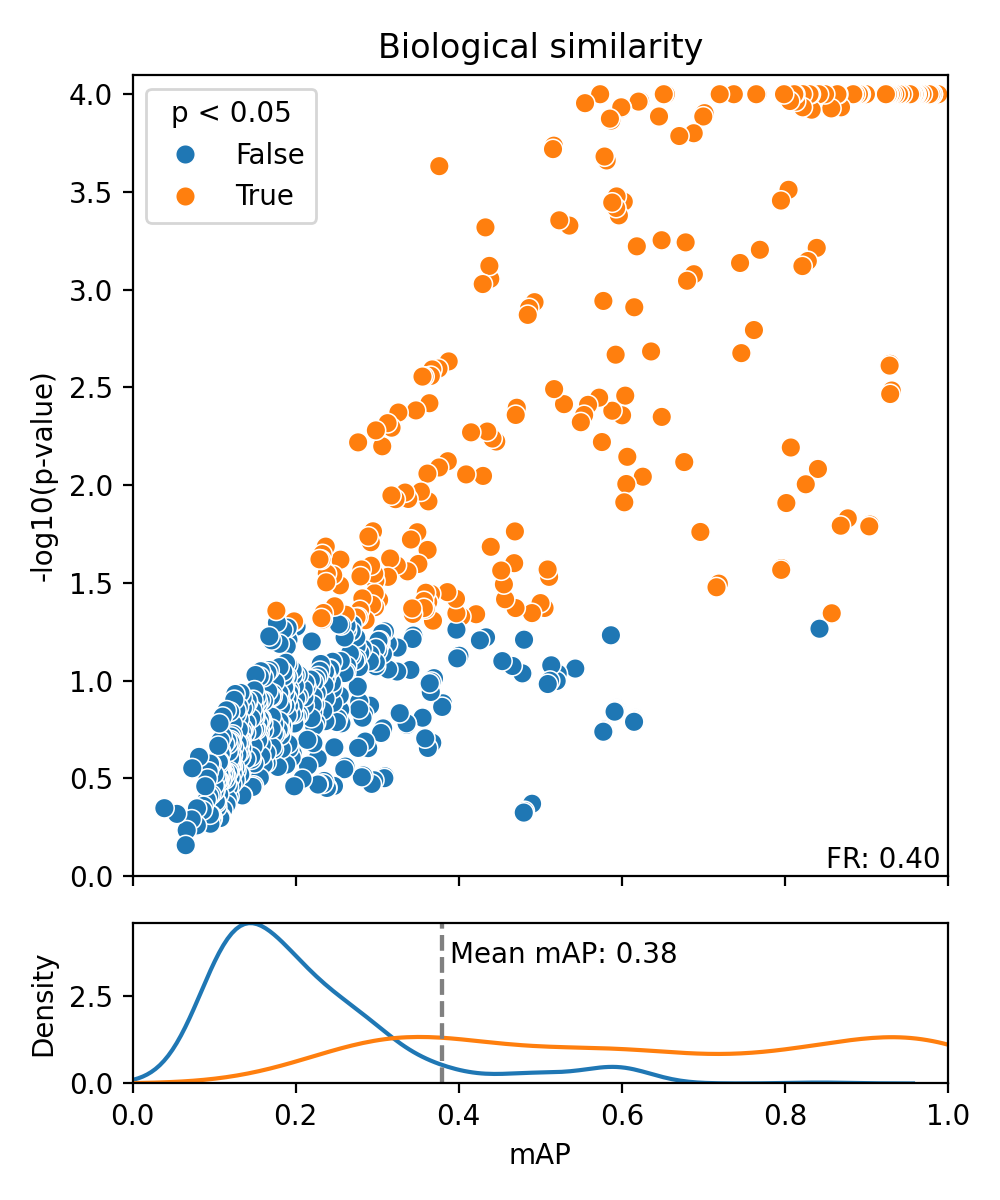

In [29]:
df = cell_health_results_df.copy()

df["mAP"] = df["mean_ap"]
df["p < 0.05"] = df["p_value"] < 0.05

def remove_inner_ticklabels(fig: plt.Figure):
    """
    Remove inner ticklabels from a figure.

    Parameters
    ----------
    fig : matplotlib.figure.Figure
        Figure to remove inner ticklabels from.
    """
    for ax in fig.axes:
        try:
            ax.label_outer()
        except AttributeError:
            pass


fig, axes = plt.subplots(2, 1, figsize=(5, 6), gridspec_kw={'height_ratios': [5, 1]})

mean_map = df['mAP'].mean()
fr = df['p < 0.05'].mean()
sns.scatterplot(
    ax=axes[0], 
    data=df, 
    x='mAP', 
    y='-log10(p-value)', 
    hue='p < 0.05',
    s=50
)
axes[0].set_title("Biological similarity")
axes[0].text(0.85, 0.01, f"FR: {fr:.2f}", transform=axes[0].transAxes)

axes[0].set_xlabel("")
axes[0].set_ylim(0, max(df['-log10(p-value)'])+0.1)
sns.move_legend(axes[0], "upper left")

# Second Row: KDE plots
max_kde_y = 0
mean_map = df['mAP'].mean()
for p_value in sorted(df['p < 0.05'].unique()):
    ax = sns.kdeplot(
        ax=axes[1],
        data=df[df['p < 0.05'] == p_value],
        x='mAP', 
        label=str(p_value)
    )
    max_kde_y = max(max_kde_y, max(ax.lines[-1].get_ydata()))
    axes[1].axvline(mean_map, color='grey', linestyle='--')
# axes[1].set_ylabel("")
axes[1].set_ylim(0, max_kde_y)
axes[1].text(mean_map+0.01, 0.75, f"Mean mAP: {mean_map:.2f}", transform=axes[1].transAxes)

for ax in axes.flat:
    ax.set_xlim(0, 1)  # Set x-axis limit to 0-1 for all subplots

remove_inner_ticklabels(fig)
plt.tight_layout()
plt.show()


In [38]:
(
    cell_health_results_df.query("ceres_score > -1.1")
    .query("mean_mean_ap > 0.5")
    .query("barcode_control == 'cutting_control'")
    .sort_values(by="ceres_score", ascending=False)
    .reset_index(drop=True)
)

,Metadata_gene_name,Metadata_pert_name,mean_ap,p_value,n_pos_pairs,n_total_pairs,cell_line,barcode_control,query,_id,DepMap_ID,stripped_cell_line_name,ceres_score,mean_mean_ap,-log10(p-value),p < 0.05
0,SLC2A2,SLC2A2-2,0.676542,0.007616,5.0,197.0,ES2,cutting_control,SLC2A2,6514,ACH-000906,ES2,-0.079741,0.741887,2.118278,True
1,ITGAV,ITGAV-1,0.993604,0.000100,11.0,203.0,ES2,cutting_control,ITGAV,3685,ACH-000906,ES2,-0.215508,0.995812,4.000043,True
2,ITGAV,ITGAV-2,0.992283,0.000100,11.0,203.0,ES2,cutting_control,ITGAV,3685,ACH-000906,ES2,-0.215508,0.995812,4.000043,True
3,CCNE1,CCNE1-2,0.648804,0.000558,11.0,203.0,HCC44,cutting_control,CCNE1,898,ACH-000667,HCC44,-0.240077,0.671436,3.253150,True
4,CCNE1,CCNE1-1,0.678274,0.000573,11.0,203.0,HCC44,cutting_control,CCNE1,898,ACH-000667,HCC44,-0.240077,0.671436,3.242096,True
5,EGLN1,EGLN1-9,0.653909,0.000100,11.0,203.0,HCC44,cutting_control,EGLN1,54583,ACH-000667,HCC44,-0.248523,0.631019,4.000043,True
6,EGLN1,EGLN1-8,0.618390,0.000600,11.0,203.0,HCC44,cutting_control,EGLN1,54583,ACH-000667,HCC44,-0.248523,0.631019,3.221892,True
7,RHOA,RHOA-2,0.953455,0.000100,11.0,203.0,HCC44,cutting_control,RHOA,387,ACH-000667,HCC44,-0.287301,0.937356,4.000043,True
8,RHOA,RHOA-1,0.940058,0.000100,11.0,203.0,HCC44,cutting_control,RHOA,387,ACH-000667,HCC44,-0.287301,0.937356,4.000043,True
9,SUZ12,SUZ12-2,0.456815,0.038316,11.0,203.0,HCC44,cutting_control,SUZ12,23512,ACH-000667,HCC44,-0.410438,0.503928,1.416618,True


In [39]:
# What are the perturbations with high grit and low ceres scores?
(
    cell_health_results_df.query("mean_mean_ap > 0.5")
    .query("ceres_score > -1")
    .query("barcode_control == 'cutting_control'")
    .sort_values(by="ceres_score")
    .reset_index(drop=True)
)

,Metadata_gene_name,Metadata_pert_name,mean_ap,p_value,n_pos_pairs,n_total_pairs,cell_line,barcode_control,query,_id,DepMap_ID,stripped_cell_line_name,ceres_score,mean_mean_ap,-log10(p-value),p < 0.05
0,BRAF,BRAF-2,0.979365,0.000100,5.0,197.0,ES2,cutting_control,BRAF,673,ACH-000906,ES2,-0.988502,0.957351,4.000043,True
1,PTK2,PTK2-2,0.821840,0.000117,11.0,203.0,HCC44,cutting_control,PTK2,5747,ACH-000667,HCC44,-0.981299,0.856377,3.933097,True
2,PTK2,PTK2-1,0.832778,0.000120,11.0,203.0,HCC44,cutting_control,PTK2,5747,ACH-000667,HCC44,-0.981299,0.856377,3.920862,True
3,GPX4,GPX4-1,0.857434,0.045212,11.0,203.0,ES2,cutting_control,GPX4,2879,ACH-000906,ES2,-0.935900,0.861359,1.344745,True
4,GPX4,GPX4-2,0.842418,0.054235,11.0,203.0,ES2,cutting_control,GPX4,2879,ACH-000906,ES2,-0.935900,0.861359,1.265724,False
5,SLC2A1,SLC2A1-1,0.586614,0.058577,5.0,197.0,ES2,cutting_control,SLC2A1,6513,ACH-000906,ES2,-0.902563,0.641459,1.232269,False
6,CDK2,CDK2-1,0.492962,0.001158,11.0,203.0,A549,cutting_control,CDK2,1017,ACH-000681,A549,-0.875199,0.526703,2.936210,True
7,CDK2,CDK2-2,0.554884,0.000111,11.0,203.0,A549,cutting_control,CDK2,1017,ACH-000681,A549,-0.875199,0.526703,3.954286,True
8,CSNK1A1,CSNK1A1-2,0.648954,0.004475,11.0,203.0,HCC44,cutting_control,CSNK1A1,1452,ACH-000667,HCC44,-0.871167,0.677450,2.349250,True
9,CSNK1A1,CSNK1A1-1,0.821940,0.000100,11.0,203.0,HCC44,cutting_control,CSNK1A1,1452,ACH-000667,HCC44,-0.871167,0.677450,4.000043,True


In [40]:
control_compare_df = cell_health_results_df.pivot(
    index=["Metadata_pert_name", "Metadata_gene_name", "cell_line", "ceres_score"],
    columns=["barcode_control"],
    values="mean_ap",
).reset_index(drop=False)

control_compare_df.head()

barcode_control,Metadata_pert_name,Metadata_gene_name,cell_line,ceres_score,cutting_control,perturbation_control
0,AKT1-1,AKT1,A549,0.057331,0.148296,0.139382
1,AKT1-1,AKT1,ES2,0.107984,0.117926,0.126259
2,AKT1-1,AKT1,HCC44,-0.122035,0.236639,0.261370
3,AKT1-2,AKT1,A549,0.057331,0.153893,0.133902
4,AKT1-2,AKT1,ES2,0.107984,0.102132,0.106171


/dgx1nas1/storage/data/akalinin/miniconda3/envs/map_benchmark/lib/python3.9/site-packages/plotnine/ggplot.py:587: PlotnineWarning: Saving 4 x 3.5 in image.
/dgx1nas1/storage/data/akalinin/miniconda3/envs/map_benchmark/lib/python3.9/site-packages/plotnine/ggplot.py:588: PlotnineWarning: Filename: figures/cell_health_barcode_control_comparison.png
/dgx1nas1/storage/data/akalinin/miniconda3/envs/map_benchmark/lib/python3.9/site-packages/plotnine/layer.py:364: PlotnineWarning: geom_point : Removed 33 rows containing missing values.


/dgx1nas1/storage/data/akalinin/miniconda3/envs/map_benchmark/lib/python3.9/site-packages/plotnine/layer.py:364: PlotnineWarning: geom_point : Removed 33 rows containing missing values.


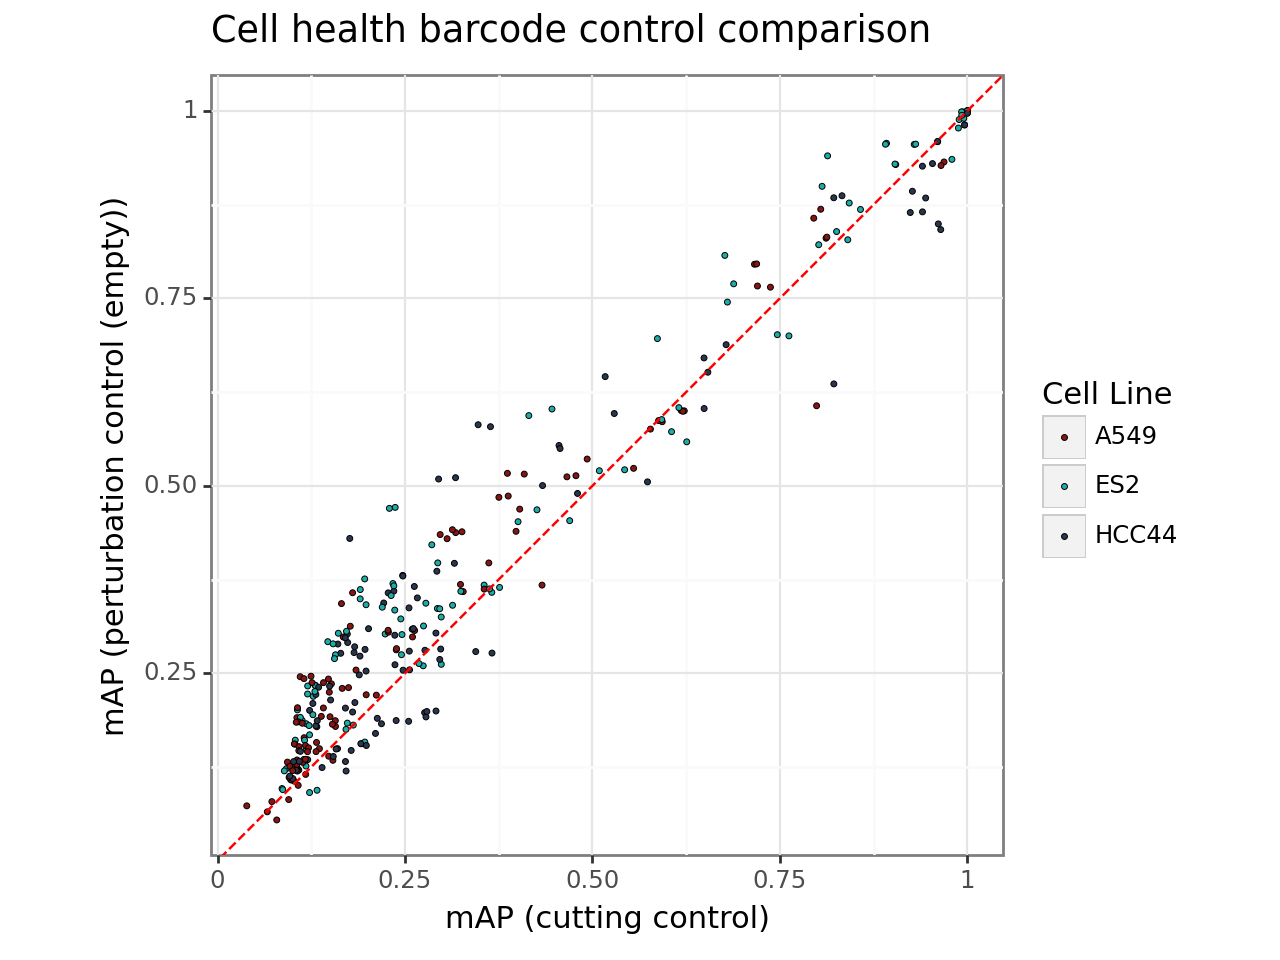

<Figure Size: (640 x 480)>

In [41]:
grit_barcode_comparison_gg = (
    gg.ggplot(control_compare_df, gg.aes(x="cutting_control", y="perturbation_control"))
    + gg.geom_point(gg.aes(fill="cell_line"), size=1, stroke=0.2)
    + gg.scale_fill_manual(name="Cell Line", values=cell_line_colors)
    + gg.theme_bw()
    + gg.xlab("mAP (cutting control)")
    + gg.ylab("mAP (perturbation control (empty))")
    + gg.ggtitle("Cell health barcode control comparison")
    + gg.geom_abline(intercept=0, slope=1, linetype="dashed", color="red")
    + gg.coord_fixed()
)

output_file = pathlib.Path(f"{output_dir}/cell_health_barcode_control_comparison.png")
grit_barcode_comparison_gg.save(output_file, dpi=500, height=3.5, width=4)

grit_barcode_comparison_gg

In [ ]:
control_compare_df = cell_health_results_df.pivot(
    index=["Metadata_pert_name", "Metadata_gene_name", "cell_line", "ceres_score"],
    columns=["barcode_control"],
    values="-log10(p-value)",
).reset_index(drop=False)

control_compare_df.head()

/dgx1nas1/storage/data/akalinin/miniconda3/envs/map_benchmark/lib/python3.9/site-packages/plotnine/ggplot.py:587: PlotnineWarning: Saving 4 x 3.5 in image.
/dgx1nas1/storage/data/akalinin/miniconda3/envs/map_benchmark/lib/python3.9/site-packages/plotnine/ggplot.py:588: PlotnineWarning: Filename: figures/cell_health_barcode_control_comparison.png
/dgx1nas1/storage/data/akalinin/miniconda3/envs/map_benchmark/lib/python3.9/site-packages/plotnine/layer.py:364: PlotnineWarning: geom_point : Removed 33 rows containing missing values.
/dgx1nas1/storage/data/akalinin/miniconda3/envs/map_benchmark/lib/python3.9/site-packages/plotnine/layer.py:364: PlotnineWarning: geom_point : Removed 33 rows containing missing values.


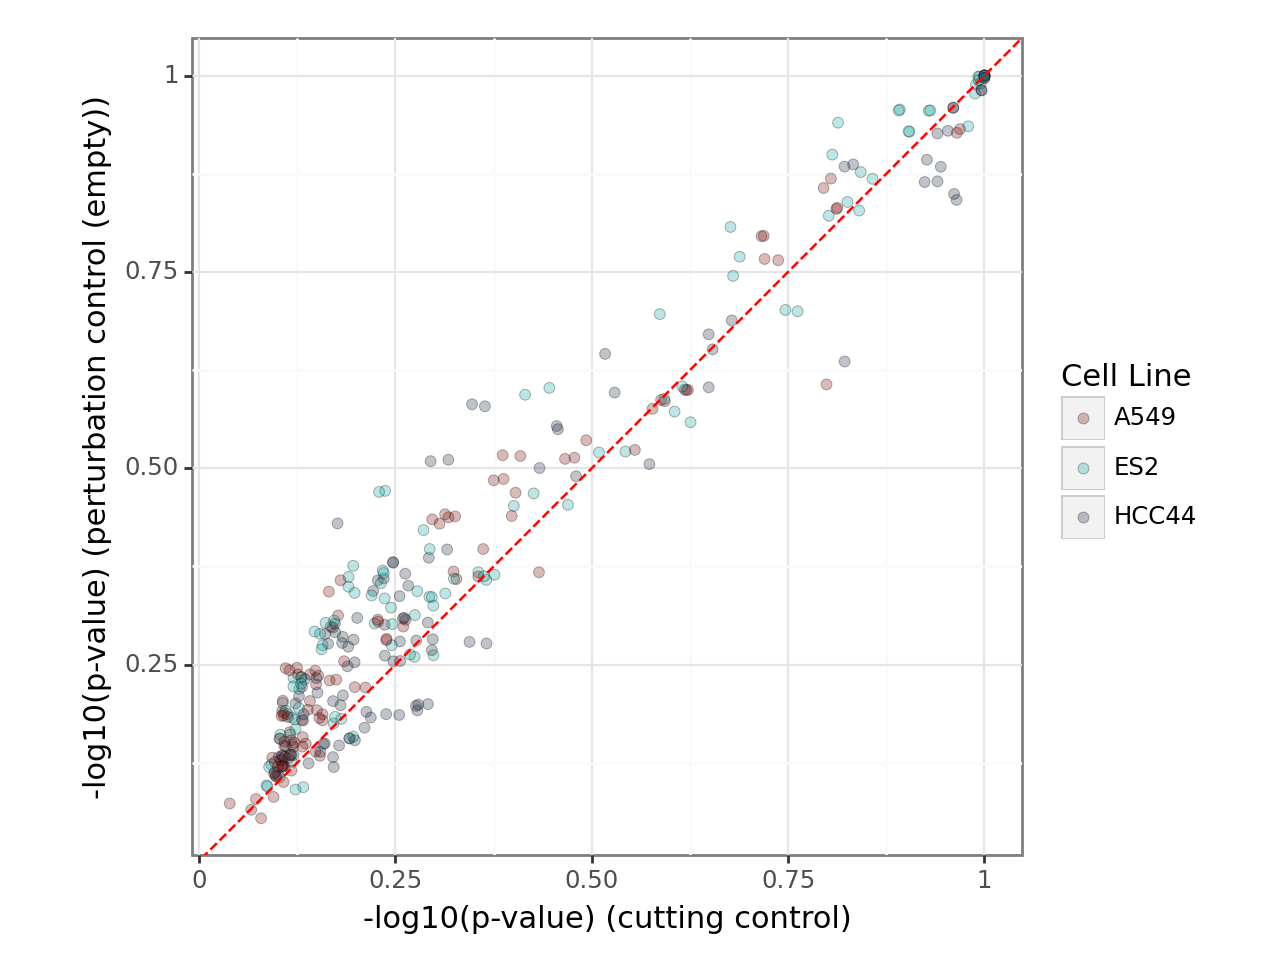

<Figure Size: (640 x 480)>

In [45]:
grit_barcode_comparison_gg = (
    gg.ggplot(control_compare_df, gg.aes(x="cutting_control", y="perturbation_control"))
    + gg.geom_point(gg.aes(fill="cell_line"), size=2, stroke=0.2, alpha=0.3)
    + gg.scale_fill_manual(name="Cell Line", values=cell_line_colors)
    + gg.theme_bw()
    + gg.xlab("-log10(p-value) (cutting control)")
    + gg.ylab("-log10(p-value) (perturbation control (empty))")
    # + gg.ggtitle("Cell health barcode control comparison")
    + gg.geom_abline(intercept=0, slope=1, linetype="dashed", color="red")
    + gg.coord_fixed()
)

output_file = pathlib.Path(f"{output_dir}/cell_health_barcode_control_comparison.png")
grit_barcode_comparison_gg.save(output_file, dpi=500, height=3.5, width=4)

grit_barcode_comparison_gg